# Portfolio Optimization using HRP

## Introduction to HRP 

Despite the global economic recession due to COVID pandemic, Dow Jones industrial average and S&P 500 recently recorded new highest averages of 34,000 and 4,200 in the first half of year 2021. These stock market indices clearly suggest growing popularity in stock investments among general population, which naturally leads to increase in competition and, consequently, risk! As a result, we decided to take this opportunity to implement a relatively stable stock portfolio, a **Hierarchical Risk Parity**, that is more risk-averse yet still lucrative.

Hierarchical Risk Parity, or HRP, is a portfolio optimization algorithm that utilizes unsupervised machine learning technique to assign investment weights to each companies in its portfolio. Contrast to HRP, Traditional optimization methods had several pivotal downfalls as below. 

1. Susceptible to random market shocks, which increases exposure to high risk 
2. Unbalanced optimization between returns and volatility, resulting in sub-optimal trade off
3. Lack of portfolio diversification

However, HRP tries to resolve these traditional downfalls by incorporating hierarchical clustering method to allocate investment weights based on proportion of inverse of variances to each of the companies. We will further elaborate in the [Performance Results](#3.-Performance-Results) section how HRP performs against 4 different traditional portfolios across various measurement metrics. 


## Table of Contents

1. [S&P 500 Stock Dataset](#1.-S&P-500-Stock-Dataset) <br>
2. [Portfolio Optimization Methods](#2.-Portfolio-Optimization-Methods) <br>
3. [Performance Results](#3.-Performance-Results)
4. [Topic Discussion](#4.-Topic-Discussion)
5. [References](#5.-References)

In [9]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)
from scipy import stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
import requests
from bs4 import BeautifulSoup

## 1. S&P 500 Stock Dataset

We employ financial data about companies listed in S&P 500 as the initial data source, since S&P 500 Index is one of the most popular index used by financial experts and includes 500+ largest companies based on market capitals and industry sectors.

### Finding S&P 500 Tickers 

The first step of collecting the S&P 500 stock dataset is finding the symbols for assets included in the S&P 500 Index. Here, we make use of `requests` and `BeautifulSoup` to read the [related page on Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies), get the S&P 500 component stocks table and retrieve the tickers listed in the 'Symbol' column.   

In [10]:
def findSP500Tickers(url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'lxml')
    SP500_table = soup.find("table", class_= "wikitable sortable")
    
    # Retrieve a pair of symbol and SEC filings for each asset [symbol, ]
    symbols_reports = SP500_table.find_all("a", class_= "external text") 
    
    # Filter the list so that we only get symbols
    tickers_raw = symbols_reports[0:len(symbols_reports):2]
    tickers = [each_symbol.get_text() for each_symbol in tickers_raw]
    
    # Replace any '.' in a ticker with '-' so that it is searchable on yahoo finance 
    tickers = [ticker.replace(".", "-") for ticker in tickers]
    return tickers 

### Finding the Adjusted Close Price 

Next, we utilize the `yfinance` library to download the data on the adjusted close price of the assets in `tickers`. The adjusted close price, different from 'close price', refers to a stock’s close price which reflects the following stock’s value after accounting for any corporate actions, such as stock splits, dividends, and right offerings. Hence, it is easier to [measure and compare the stocks' performance](https://www.investopedia.com/terms/a/adjusted_closing_price.asp#:~:text=price-,Benefits%20of%20the%20Adjusted,without%20adjusted%20closing%20prices,-Secondly). 

To save time downloading the data, we have saved the output of `getAdjClose()` in 'sp500_data.csv'.

In [11]:
def getAdjClose(tickers):
    data = yf.download(tickers)["Adj Close"]
    return data

In [12]:
data = pd.read_csv("sp500_data.csv", index_col = 0, parse_dates = True)
data.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.104839,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.106396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.106656,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.104320,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.104061,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Processing the Data

As observed above, not all the corporates currently listed under the S&P 500 Index were founded or open to the public before S&P 500 was introduced, so this current data set must be processed. We first look for the `start_year` in which at least `threshold` * 100 % of data are maintained. Note that we have set the threshold to be **0.5** as we wanted over 30 years of accumulative data for backtesting while keeping as reasonably many companies as possible. 

In [13]:
def findStartingYear(data, threshold):
    years = sorted(list(set(data.index.year)))
    num_assets = len(data.columns)
    start_year = 0
    for year in years:
        yearly_data = data.loc[data.index.year == year]
        first_date_data = yearly_data.iloc[0,]
        valid = pd.notna(first_date_data).astype(int).sum()
        if valid >= num_assets * threshold:
            start_year = year
            break
    return start_year

In [14]:
start_year = findStartingYear(data, 0.5)
print(start_year)

1989


`process_data()` only keeps the companies that have had IPO before `start_year` (i.e. before 1989) and calculates the percent change of the adjusted close prices to retrieve daily returns of each asset.

In [15]:
def process_data(data, start_year, end_year = 2021):
    processed = data.loc[data.index.year >= start_year]
    processed = processed.loc[processed.index.year < end_year]
    valid_tickers_series = processed.loc[processed.index.year == start_year].iloc[0, ].dropna()
    valid_tickers = valid_tickers_series.index.values.tolist()
    output = processed[valid_tickers].pct_change().dropna()
    return output

In [44]:
returns = process_data(data, start_year)
returns.head()

,AAPL,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEP,AFL,...,WM,WMB,WMT,WRB,WST,WY,XEL,XOM,XRAY,ZION
Date,,,,,,,,,,,,,,,,,,,,,
1989-01-04,0.040248,0.096386,0.015707,0.040816,0.019999,0.024243,0.012861,0.016807,0.014085,0.027778,...,0.000000,0.020921,0.016461,0.004220,-0.007937,0.020305,0.011583,0.017342,0.000000,0.000000
1989-01-05,0.005952,0.010989,-0.002578,0.005891,-0.009804,0.023668,0.003174,-0.008265,0.000000,-0.009009,...,0.052632,0.020492,0.004049,0.000000,0.008001,-0.009951,-0.003818,0.008523,-0.035714,-0.033707
1989-01-06,0.008876,0.000000,-0.012919,-0.020000,0.000000,-0.017341,0.015823,-0.025000,-0.004629,-0.009091,...,0.000000,0.028113,0.000000,-0.008403,0.000000,0.030151,0.007664,0.002816,0.000000,0.023255
1989-01-09,0.008798,-0.065217,-0.014754,0.000000,0.000000,-0.011765,-0.034268,0.000000,0.000000,0.018349,...,0.000000,-0.003906,-0.008064,0.025424,0.007936,0.004878,0.003802,-0.002808,0.074074,0.000000
1989-01-10,-0.008721,0.023256,0.000000,-0.015306,0.000000,-0.005952,0.006451,0.004274,0.004651,0.009009,...,0.100000,0.000000,0.008130,0.016529,0.007874,0.014563,-0.003787,-0.008451,0.000000,-0.068182


## 2. Portfolio Optimization Methods

The portfolio optimization methods mentioned in this section are long-only, meaning that sum of all the weights = 1 and each weight >=0. 

Weight-adjusted returns of each optimized portfolio are calculated by 
1. multiplying each asset's daily return by the number of days 
2. finding the dot product of the result from 1 and the weights assigned by the portfolio

Each portfolio's volatility is computed using the following formula:
$$\sigma_{\textrm{Portfolio}} = \sqrt{w^T \cdot \textrm{cov} \cdot w}$$
where $w$ is the weights assigned by the portfolio and $\textrm{cov}$ is the covariance matrix of the weights times the number of days.

In [17]:
def getReturns(weights,returns,days):
    period_returns = np.array(returns * days)
    weight_allocated_returns = np.dot(period_returns,weights)
    return weight_allocated_returns

def getVolatility(weights, cov, days):
    wT_dot_cov = np.dot(weights.T, cov*days)
    return np.sqrt(np.dot(wT_dot_cov, weights))

### 2.1. Traditional Methods 

There are traditional methods of portfolio optimization that do not implement any machine learning algorithms. Portfolios formed using such methods are discussed below.

### Inverse Variance Portfolio 

The inverse variance portfolio assigns weights to each asset by finding the proportion of the inverse of the variance per each asset to the sum of total inverse variances. Thus, for *n* number of assets, the weight of each asset $i$ is calculated by:

$$\textrm{weight}_{i} = \frac{\textrm{Var}_{i}^{-1}}{\sum \limits _{i = 1} ^{n} \textrm{Var}_{i}^{-1}}$$

In [18]:
def IVP(returns):
    returns_cov = returns.cov()
    inv = 1/np.diag(returns_cov)
    weight = inv/np.sum(inv)
    return weight

### Maximum Return Portfolio, Minimum Volatility Portfolio (Efficient Frontier) 

Using the Monte Carlo method, we can generate random weights for each asset and create different combinations of return and volatility. Among these combinations, some form what is called an "efficient frontier" on the graph. Each point on the efficient frontier is the optimal combination of return and volatility; given any level of volatility, you can find the maximized return and each asset's weight associated with it.  

For our purposes, we make 10,000 different portfolios with random weights and find the weights that give maximum returns and minimum volatility. 

In [49]:
np.random.seed(15388) #15-388!

def efficientFrontier(annual_returns, port_nums = 10000):
    averaged_returns = annual_returns.mean() * len(annual_returns)
    assets_num = len(averaged_returns)
    portfolio_returns = []
    portfolio_volatility = []
    weights = []
    num_day = len(annual_returns.index)
    for portfolio in range(port_nums):
        random_weights = np.random.random(assets_num)
        random_weights /= np.sum(random_weights)
        port_return = np.dot(random_weights, averaged_returns)
        port_vol = getVolatility(random_weights, annual_returns.cov(),num_day)
        portfolio_returns.append(port_return)
        portfolio_volatility.append(port_vol)
        weights.append(random_weights)
    weights_by_returns = {}
    weights_by_vol = {}
    for i in range(len(weights)):
        weights_by_returns[portfolio_returns[i]] = weights[i]
        weights_by_vol[portfolio_volatility[i]] = weights[i]
    max_return = max(portfolio_returns)
    min_vol = min(portfolio_volatility)
    max_return_weights = weights_by_returns[max_return]
    min_vol_weights = weights_by_vol[min_vol]
    return max_return_weights, min_vol_weights

### Equally Weighted Portfolio

For *n* number of assets, the equally weighted portfolio, as the name suggests, simply assigns 1/n weight to each portfolio.
$$\textrm{weight}_{i} = \frac{1}{n}$$

In [20]:
def EWP(returns):
    num_assets = len(returns.columns)
    weight = np.ones(num_assets)
    weight = np.true_divide(weight, num_assets)
    return weight

### 2.2. Hierarchical Risk Parity Portfolio

HRP Portfolio algorithm can primarily be broken down into three separate optimizing stages. 
1. Hierarchical Clustering
2. Quasi-Diagnolization
3. Recursive Bisection

### Hierarchical Clustering 

We follow the same approach outlined in the [original implementation](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678) and apply the **single linkage** method when implementing the hierarchical clustering on the distance matrix of the returns' correlation matrix.  

In [21]:
#1. Hierarchical Clustering 

def hierarchical_clustering(corr):
    corr_dist_matrix = np.sqrt((0.5 * (1 - corr)))
    hier_cluster = sch.linkage(corr_dist_matrix, 'single')
    return hier_cluster

### Quasi-Diagnolization 

In this step, we will be applying *quasi-diagonalization* to a hierarchical cluster from `hierarchical_clustering()`. Simply put, *quasi-diagonalization* accomplishes the same functionality as *matrix seriation*, where in this case we will be reordering pre-defined company orders to a new set of company orderings based on hierarchical cluster. Specifically, we will extract clustering assignments and company indices from hierarchical cluster and use that information to make a new company ordering index. 

The steps are as follow: 

1. We extract the "highest" cluster, the cluster that groups entire data, that is located in the last index of `hier_cluster` to obtain leaf-clusters in the first two indices and total number of companies in its last index. 

2. We iterate until all `child_clusters` are filled with singletons, or index of individual companies.

3. Within the iteration, we separate each cluster's leaf-clusters into either `children` or `singleton` variables, and store those information into a new company ordering index, where singleton variables are retained but `children` variables are passed down the iteration until they are fully decomposed into individual companies.

In [22]:
#2. Quasi-Diagnolization 

def quasi_diagonalization(hier_cluster, company_order):
    hier_cluster = np.int64(hier_cluster)
    top_cluster_index = hier_cluster.shape[0] - 1
    child_1 = hier_cluster[top_cluster_index,0]
    child_2 = hier_cluster[top_cluster_index,1]
    tot_companies = hier_cluster[top_cluster_index,3]
    child_clusters = pd.Series([child_1,child_2])
    
    # cluster indexing cannot exceed tot_companies + i.
    while child_clusters.max() - tot_companies >= 0: 
        max_childnum = child_clusters.shape[0] * 2 
        elongated_index = pd.RangeIndex(start = 0, stop = max_childnum)
        storage = pd.Series(index = elongated_index)
        children_index = child_clusters[child_clusters - tot_companies >= 0]
        singleton_index = child_clusters[child_clusters - tot_companies < 0]
        new_children_index = np.int64(children_index.values - tot_companies)
        new_child_1 = hier_cluster[new_children_index,0]
        new_child_2 = hier_cluster[new_children_index,1]
        new_child_1 = np.reshape(new_child_1,(new_child_1.shape[0],1))
        new_child_2= np.reshape(new_child_2,(new_child_2.shape[0],1))
        combine_child = np.concatenate((new_child_1,new_child_2),axis = 1).flatten()
        indexer = 0
        temp_indexer = 0
        result = []
        tot_length = len(singleton_index) + len(combine_child)
        while True:
            if indexer in singleton_index.index:
                elem = singleton_index[indexer]
                result.append(elem)
            else:
                elem1 = combine_child[0]
                elem2 = combine_child[1]
                result.append(elem1)
                result.append(elem2)
                combine_child = np.delete(combine_child, 0)
                combine_child = np.delete(combine_child, 0)
                temp_indexer += 1
            indexer += 1
            temp_indexer += 1
            if len(result) == tot_length:
                break
        for i in range(storage.shape[0]):
            storage[i] = result[i]
            if i+1 == len(result):
                break
        child_clusters = storage.dropna().astype(int)
    hier_order = company_order[child_clusters]
    hier_order = hier_order.tolist()
    return hier_order

### Recursive Bisection 

After quasi-diagnolization, for all *n* assets in the sorted list, we set their weight to 1. Then we follow the recursive bisection algorithm, listed in the example of [Asset Allocation - Hierarchical Risk Parity ](https://www.mathworks.com/matlabcentral/fileexchange/70186-asset-allocation-hierarchical-risk-parity). Note that all the assets start from a single cluster. 

The steps are as follows:
1. We "bisect" each cluster into left and right, so that we have *k* many left/right pair(s) where k = the number of original cluster(s).   
2. Then we calculate the weights for all the assets in the left cluster and the weights for all the assets in the right cluster for each left/right pair. $$w_i = \frac{\textrm{var}_i^{-1}}{\sum \limits _{i = 1} ^{j} \textrm{var}_{i}^{-1}}$$ where j = total number of assets in the cluster.
3. We then calculate the total variance of each cluster (left/right) by $$\textrm{Var} = w^T * \textrm{cov} * w$$
4. Now, we compute the splitting factor for each cluster (left/right). Here we tweaked the original formula mentioned in the resource above to avoid division by 0 error.
$$a_{\textrm{left}} = \frac{1/\textrm{Var}_{\textrm{left}}}{1/\textrm{Var}_{\textrm{left}} + 1/\textrm{Var}_{\textrm{right}}} = \frac{1/\textrm{Var}_{\textrm{left}}}{(\textrm{Var}_{\textrm{left}} + \textrm{Var}_{\textrm{right}})/(\textrm{Var}_{\textrm{left}}*\textrm{Var}_{\textrm{right}})} = \frac{\textrm{Var}_{\textrm{right}}}{\textrm{Var}_{\textrm{left}}+\textrm{Var}_{\textrm{right}}}$$ <br>
$$a_{\textrm{right}} = 1 - a_{\textrm{left}}$$
5. We rescale the weight of each asset in each cluster by multiplying the associated splitting factor, i.e. multiplying weights of the assets in the left cluster by $a_{\textrm{left}}$ 
$$w_{\textrm{left}} = w_{\textrm{left}} * a_{\textrm{left}}$$ <br>
$$w_{\textrm{right}} = w_{\textrm{right}} * a_{\textrm{right}}$$
6. Repeat steps 1-5 until each asset is in its own cluster


In [23]:
#3. Recursive Bisection 

def total_variance(cov):
    # Step 2, 3
    inv = 1/np.diag(cov)
    weights = inv/np.sum(inv)
    weights = weights.reshape(-1,1)
    
    weights_T = weights.T
    weights_T_dot_covar = np.dot(weights.T, cov)
    total_var = np.dot(weights_T_dot_covar, weights).item(0)
    return total_var

def recursive_bisection(cov, hier_order):
    
    # Initialize each weight as 1 
    weight = pd.Series(1, index=hier_order)
    
    # Put all the assets into a single cluster initially 
    clusters = [hier_order]  
    
    not_all_singleton = True
    
    # Repeat until each is assigned to a singleton cluster 
    while not_all_singleton:
        tmp_list = []
        # Step 1
        for each_cluster in clusters:
            half_len = len(each_cluster)//2
            left = each_cluster[:half_len]
            right = each_cluster[half_len:]
            tmp_list.append(left)
            tmp_list.append(right)
        clusters = tmp_list
        i = 0
        while i < len(clusters):
            left_half = clusters[i]
            right_half = clusters[i+1]
            left_covars = cov.loc[left_half, left_half]
            right_covars = cov.loc[right_half, right_half]
            
            # Step 2, 3
            left_total_var = total_variance(left_covars)
            right_total_var = total_variance(right_covars)
            
            # Step 4
            alpha_left = right_total_var/(left_total_var + right_total_var)
            alpha_right = 1-alpha_left
            
            # If not in a singleton cluster 
            if alpha_left != 1:
                weight[left_half] *= alpha_left
                weight[right_half] *= alpha_right
            i += 2
        parents_count = 0
        for each_cluster in clusters:
            if len(each_cluster) > 1:
                parents_count += 1
        if parents_count == 0:
            not_all_singleton = False
    return weight

In [46]:
def HRP(returns):
    
    returns_corr = returns.corr()
    returns_cov = returns.cov()
    company_list = returns.columns
    
    # Construct a hierarchical portfolio
    
    hier_cluster = hierarchical_clustering(returns_corr) 
    hier_order = quasi_diagonalization(hier_cluster,company_list)
    hrp = recursive_bisection(returns_cov, hier_order)
    
    # Uncomment `dn` to see the dendrogram of each year's HRP portfolio
    #dn = sch.dendrogram(hier_cluster, labels= returns_cov.index.values, leaf_rotation=90)
    
    return hrp

Lastly, we construct portfolios using each optimization method aforementioned.

In [25]:
def optimize_portfolios(returns):
    port_index = returns.columns 
    
    hrp = HRP(returns)
    ivp = IVP(returns)
    max_returns, min_vol = efficientFrontier(returns)
    eq_weight = EWP(returns)
    
    hrp = pd.Series(hrp, index = port_index)
    ivp = pd.Series(ivp, index=port_index)
    max_returns = pd.Series(max_returns, index = port_index)
    min_vol = pd.Series(min_vol, index = port_index)
    eq_weight = pd.Series(eq_weight, index = port_index)
    
    portfolios = pd.DataFrame([ivp, hrp, max_returns, min_vol, eq_weight], index=['IVP', 'HRP', "max_returns", "min_vol", "eq_weight"]).T
    
    return portfolios

## 3. Performance Results

Now, time to test HRP and other traditional methods against our stock returns data!

The function `performance()` defined below takes in stock returns data and returns annual returns, volatility, and efficiency for each portfolio optimization method. The way optimization and performances are measured is done through [historical-walk-forward-backtesting](https://research.cbs.dk/en/studentProjects/exploration-of-hierarchical-clustering-in-long-only-risk-based-po). This backtesting method optimizes portfolio using some arbitrary year 1 and 2's data, or equivalent `buffer_data`, and apply portfolio's allocated weights to some arbitrary year 3's data, or `test_data`, to compute out-of-sample annual returns and volatility.

In [26]:
def performance(returns):
    # derive weights from buffer(train) data and measure portfolio performance on test data
    
    years = sorted(list(set(returns.index.year)))
    buffer_length = 2
    year_index = years[buffer_length:]
    performance_index = ["Returns", "Volatility"]
    portfolio_names = ["IVP","HRP","Maximum Returns","Minimum Volatility","Equally-weighted"]
    IVP_result = pd.DataFrame(index = year_index, columns = performance_index)
    HRP_result = pd.DataFrame(index = year_index, columns = performance_index)
    EF1_result = pd.DataFrame(index = year_index, columns = performance_index)
    EF2_result = pd.DataFrame(index = year_index, columns = performance_index)
    eq_result = pd.DataFrame(index = year_index, columns = performance_index)
    for i in range(len(years) - buffer_length):

        #buffer(train) data allocation
        buffer_period = years[i + 1]
        buffer_data = returns.loc[returns.index.year <= buffer_period]
        
        #test data allocation and information extraction
        test_period = years[i + buffer_length]
        print(test_period)
        test_data = returns.loc[returns.index.year == test_period]
        test_days = len(test_data.index)
        test_daily_returns = test_data.mean()
        test_returns_cov = test_data.cov()
        
        #portfolio optimization
        portfolios = optimize_portfolios(buffer_data)
        ivp_weights = portfolios['IVP']
        hrp_weights = portfolios['HRP']
        EF1_weights = portfolios['max_returns']
        EF2_weights = portfolios['min_vol']
        eq_weights = portfolios['eq_weight']
        
        #annual performance measurements 
        for metric in performance_index: 
            if metric == "Returns":
                IVP_result.loc[test_period,metric] = getReturns(ivp_weights,test_daily_returns,test_days)
                HRP_result.loc[test_period,metric] = getReturns(hrp_weights,test_daily_returns,test_days)
                EF1_result.loc[test_period,metric] = getReturns(EF1_weights,test_daily_returns,test_days)
                EF2_result.loc[test_period,metric] = getReturns(EF2_weights,test_daily_returns,test_days)
                eq_result.loc[test_period,metric] = getReturns(eq_weights,test_daily_returns,test_days)
            if metric == "Volatility":
                IVP_result.loc[test_period,metric] = getVolatility(ivp_weights, test_returns_cov, test_days)
                HRP_result.loc[test_period,metric] = getVolatility(hrp_weights, test_returns_cov, test_days)
                EF1_result.loc[test_period,metric] = getVolatility(EF1_weights, test_returns_cov, test_days)
                EF2_result.loc[test_period,metric] = getVolatility(EF2_weights, test_returns_cov, test_days)
                eq_result.loc[test_period,metric] = getVolatility(eq_weights, test_returns_cov, test_days)
    port_returns = pd.concat([IVP_result.dropna()["Returns"],
                    HRP_result.dropna()["Returns"],
                    EF1_result.dropna()["Returns"],
                    EF2_result.dropna()["Returns"],
                    eq_result.dropna()["Returns"]],axis='columns')
    port_volatility = pd.concat([IVP_result.dropna()["Volatility"],
                    HRP_result.dropna()["Volatility"],
                    EF1_result.dropna()["Volatility"],
                    EF2_result.dropna()["Volatility"],
                    eq_result.dropna()["Volatility"]],axis='columns')
    port_returns.columns = portfolio_names
    port_volatility.columns = portfolio_names
    port_efficiency = port_returns / port_volatility
    return port_returns, port_volatility, port_efficiency

Due to massive volume of our data, we computed annual returns, volatility, and efficiency of each portfolio for you and stored into `.csv` files. Below, we read in these files into each variables named `port_returns`, `port_volatility`, and `port_efficiency`. 

Note : *Portfolio efficiency* is a measure of the amount of reward per unit of risk taken produced by a portfolio, and is computed by dividing annual returns by annual volatility.

In [28]:
port_returns = pd.read_csv("port_returns.csv",index_col=0,parse_dates=True)
port_volatility = pd.read_csv("port_volatility.csv",index_col=0,parse_dates=True)
port_efficiency = pd.read_csv("port_efficiency.csv",index_col=0,parse_dates=True)

Below plot represents change in annual performance metrics for each portfolio, where HRP is colored in orange. There are few things to note from these graphical displays. 

1. HRP, on average, had highest returns when annual returns decreased across all portfolios during economic recession.

2. HRP performed pretty decently during economic expansion periods by producing annual returns that are comparable to those of other high-performing portfolios. 

3. HRP always had the lowest annual volatility across all out-of-sample time periods. 

We can confirm that HRP is a relatively more risk-averse portfolio optimization method that is less vulnerable to random market shocks, which is partly accomplished by portfolio diversification from [hierarchical clustering](#Hierarchical-Clustering) of companies across different industries and partly by [recursive bisection](#Recursive-Bisection) described above. 

<AxesSubplot:title={'center':'Change in Annual Volatility per Portfolio'}>

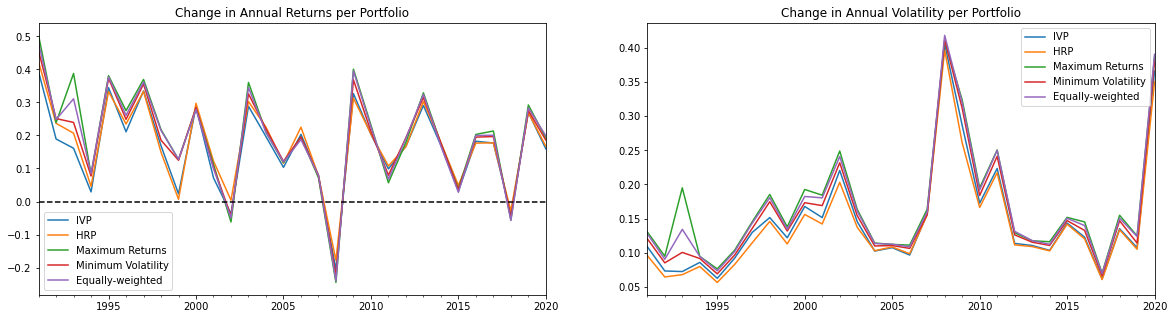

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2)

port_returns.plot(ax=axes[0], figsize = (20,5), title = "Change in Annual Returns per Portfolio").axhline(y=0, color='black', linestyle='--')
port_volatility.plot(ax=axes[1], figsize = (20,5), title = "Change in Annual Volatility per Portfolio")

In fact, we were able to confirm our results by comparing the average of annual portfolio efficiency. From the results below, we can see that HRP has highest portfolio efficiency of **1.716081** compared to other ones! We are obtaining such outcome because HRP finds an optimal balancing point between maximizing returns and minimizing variance, as illustrated from the plots above. 

In [30]:
port_efficiency.mean(axis = 0)

IVP                   1.505974
HRP                   1.716081
Maximum Returns       1.518332
Minimum Volatility    1.580237
Equally-weighted      1.531394
dtype: float64

Although we have sound results, we need to statistically validate our findings to assure that HRP does indeed produce such promising returns. Using one sample t hypothesis testing, we tested HRP's annual portfolio returns and volatility against their null hypotheses. Because the test returns two-tailed t test results, we divide the p-value by 2 as we are only verifying whether annual returns is greater than 0.

In [33]:
null_hypothesis_returns = 0.0
null_hypothesis_volatility = 0.1780
t_stat_returns, p_value_returns = stats.ttest_1samp(port_returns['HRP'], null_hypothesis_returns)
t_stat_volatility, p_value_volatility = stats.ttest_1samp(port_volatility['HRP'], null_hypothesis_volatility)
p_value_returns =  p_value_returns / 2
p_value_volatility =  p_value_volatility / 2
print("t test statistics of returns = ", t_stat_returns)
print("p value of returns = ", p_value_returns)
print("t test statistics of volatility = ", t_stat_volatility)
print("p value of volatilty = ", p_value_volatility)

t test statistics of returns =  7.461064343161038
p value of returns =  1.5954103731788852e-08
t test statistics of volatility =  -2.6401655038626695
p value of volatilty =  0.00660096026848957


At significance level of $\alpha$ = 0.05, there is a strong statistical evidence to reject the null hypothesis that HRP's portfolio returns is zero. The alternative hypothesis may be true in that the true annual portfolio returns > 0. In similar reasoning, the alternative hypothesis may be true in that the true annual portfolio volatility is less than S&P 500's average volatility of 0.1780. Thus, as our sample size >= 30, we have shown that by the Law of Large Numbers, HRP is a profitable and risk-averse portfolio!

## 4. Topic Discussion

For this report, we employed the single linkage method for hierarchical clustering, but there are other linkage methods such as complete, average, ward, etc. The overall balance of the clusters depends on the choice of linkage method and thus the weight assignments may vary by the linkage method.    

One potential limitation to this implementation may be the absence of varying long, short, and hold positions. If we were to somehow incorporate these decisions into our portfolio, we could have produced better performance results, assuming that we take appropriate positions based on a investment strategy. 

HRP is versatile in a way that it could essentially be applied to any other asset markets. Particularly, we thought that HRP may suit the cryptocurrency market, as not only are there hundreds of different coins available to assign different clustering, but also HRP may fight well against the market's notoriously fickle stock prices. Although there are no previous precedents of HRP being utilized in other asset market, it is worthwhile to investigate how this portfolio optimization algorithm would perform in other areas to realize its potential!

## 5. References 

References used in writing this report are provided below for anyone interested in further investigation

* [Building Diversified Portfolios that Outperform Out-of-Sample](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678)
* [Exploration of Hierarchical Clustering in Long-only Risk-based Portfolio Optimization](https://research.cbs.dk/en/studentProjects/exploration-of-hierarchical-clustering-in-long-only-risk-based-po)
* [The Hierarchical Risk Parity Algorithm: An Introduction](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/)
* [Asset Allocation - Hierarchical Risk Parity](https://www.mathworks.com/matlabcentral/fileexchange/70186-asset-allocation-hierarchical-risk-parity)